# FasterRCNN Prediction Object

In [22]:
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### Data

For example, let's pick the first image from Hamburg from CityScapes dataset. I saved it to data directory:

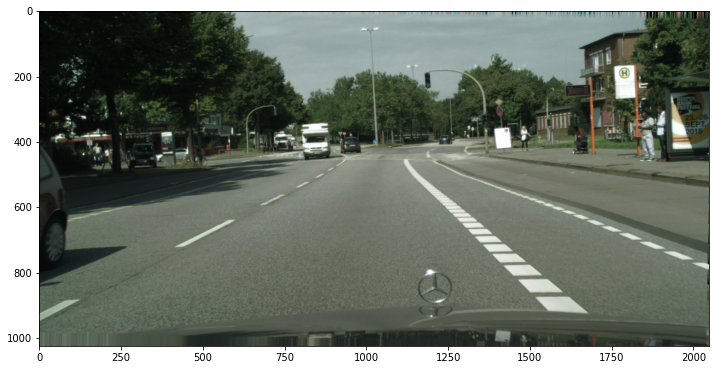

In [11]:
img_name = 'hamburg_000000_000042_leftImg8bit'

img = Image.open('../data/' + img_name + '.png')
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img);

### Ground truth

And check the ground truth annotations from CityPersons dataset:

In [5]:
with open('../data/ground-truth-annotations-0.pickle', 'rb') as fp:
    gt0 = pickle.load(fp)

In `gt0` we saved the ground truth bounding boxes:

In [6]:
gt0

[array([682, 401,  13,  33], dtype=uint16),
 array([202, 418,  20,  50], dtype=uint16),
 array([166, 403,  30,  71], dtype=uint16),
 array([1343,  369,    6,   15], dtype=uint16),
 array([1637,  352,   30,   73], dtype=uint16),
 array([1826,  308,   62,  150], dtype=uint16),
 array([1867,  291,   69,  168], dtype=uint16),
 array([1469,  352,   31,   76], dtype=uint16)]

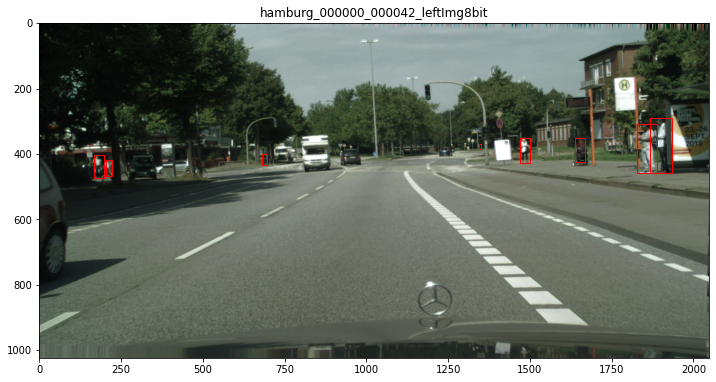

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
ax.imshow(img);

# bbox = [x, y, w, h]
for bbox in gt0:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

### Prediction from FasterRCNN

I saved the prediction:

```python
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
```

To `data` directory, which we can load:

In [16]:
with open('../data/prediction-0.pickle', 'rb') as fp:
    prediction = pickle.load(fp)

In [17]:
type(prediction)

dict

In [18]:
prediction

{'boxes': tensor([[1867.6996,  290.0706, 1935.4948,  457.9046],
         [1825.1581,  304.0287, 1889.9994,  457.7863],
         [1470.5577,  350.1487, 1499.6713,  426.3264],
         [ 164.0272,  403.8603,  191.3489,  474.3809],
         [1633.3987,  347.1248, 1670.2074,  433.6295],
         [ 203.7215,  418.0811,  224.0584,  467.4494],
         [ 692.3051,  399.4909,  705.6819,  431.1591],
         [ 718.3954,  396.5953,  730.8055,  428.0432],
         [ 469.8653,  405.0747,  493.8742,  465.2343],
         [ 688.6938,  401.5743,  699.9677,  431.3632],
         [ 699.0222,  400.2999,  708.7267,  429.4056],
         [ 196.3171,  421.6237,  217.0280,  470.3988],
         [ 682.9064,  397.6649,  696.6857,  431.2079],
         [ 265.0278,  426.7236,  281.0891,  464.4976],
         [ 244.1873,  420.7523,  260.9995,  462.7815],
         [ 723.4791,  400.8794,  733.6397,  427.0487],
         [1020.6530,  389.3322, 1031.0763,  414.2762],
         [ 715.3606,  399.4365,  726.7148,  428.1268],
 

We can translate it to numpy arrays:

In [19]:
preds = prediction['boxes'] # predicted bboxes
preds = preds.cpu().data.numpy() # to numpy array

scores = prediction['scores'] # scores of predicted bboxes
scores = scores.cpu().data.numpy()

Say, we keep only bboxes where score > threshold:

In [23]:
threshold = .3
highs = list(np.where(scores > threshold)[0])
bboxes_x0x1y0y1 = []
for high in highs:
    bboxes_x0x1y0y1.append(list(preds[high]))

And transform back to [x, y, w, h] format:

In [24]:
bboxes = []
for bbox in bboxes_x0x1y0y1:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])

Draw the predicted bounding boxes:

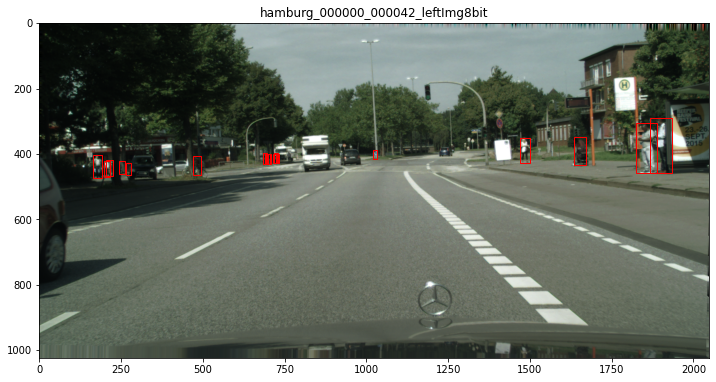

In [25]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img);

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

### Evaluation

TODO: 
If possible, using ground truth bounding boxes `gt0` object and predicted bounding boxes `bboxes` and COCO tools to calculate MR measure for this example. Goal is to then run the same on all predictions for the test set and put our model on (this)[https://github.com/cvgroup-njust/CityPersons] benchmark table:

### Benchmark ###

|         Method         | External   training data | MR (Reasonable) | MR (Reasonable_small) | MR (Reasonable_occ=heavy) | MR (All) |
|:----------------------:|:----------------------:|:---------------:|:---------------------:|:-------------------------:|:--------:|
| [APD-pretrain](https://arxiv.org/abs/1910.09188) |  √ |      7.31%     |         10.81%        |           28.07%          |  32.71%  |
| [Pedestron](https://arxiv.org/abs/2003.08799) |  √ |      7.69%     |         9.16%        |           27.08%          |  28.33%  |
| [APD](https://arxiv.org/abs/1910.09188) |  ×  |      8.27%     |         11.03%        |           35.45%          |  35.65%  |
| YT-PedDet |  ×  |      8.41%     |         10.60%        |           37.88%          |  37.22%  |
| STNet |  ×  |      8.92%     |         11.13%        |           34.31%          |  29.54%  |
| [MGAN](https://arxiv.org/abs/1910.06160) |  ×  |      9.29%     |         11.38%        |           40.97%          |  38.86%  |
| DVRNet |  ×  |      11.17%     |         15.62%        |           42.52%          |  40.99%  |
| **OurModel** |  ×  |      **TODO**     |        **TODO**       |           **TODO**         |  **TODO**  |
| [HBA-RCNN](https://arxiv.org/abs/1911.11985) |  ×  |      11.26%     |         15.68%        |           39.54%          |  38.77%  |
| [OR-CNN](https://arxiv.org/abs/1807.08407)     |  ×  |      11.32%     |         14.19%        |           51.43%          |  40.19%  |
| [AdaptiveNMS](http://openaccess.thecvf.com/content_CVPR_2019/papers/Liu_Adaptive_NMS_Refining_Pedestrian_Detection_in_a_Crowd_CVPR_2019_paper.pdf)     |  ×  |      11.40%     |         13.64%        |           46.99%          |  38.89%  |
| [Repultion Loss](http://arxiv.org/abs/1711.07752)     |  ×  |      11.48%     |         15.67%        |           52.59%          |  39.17%  |
| [Cascade MS-CNN](https://arxiv.org/abs/1906.09756)     |  ×  |      11.62%     |         13.64%        |           47.14%          |  37.63%  |
| [Adapted FasterRCNN](http://202.119.95.70/cache/12/03/openaccess.thecvf.com/f36bf52f1783160552c75ae3cd300e84/Zhang_CityPersons_A_Diverse_CVPR_2017_paper.pdf)  |  ×  |      12.97%     |         37.24%        |           50.47%          |  43.86%  |
| [MS-CNN](https://arxiv.org/abs/1607.07155)     |  ×  |      13.32%     |         15.86%        |           51.88%          |  39.94%  |

[comment]: <![leaderboard.png](https://bitbucket.org/repo/XXegAKG/images/1374766803-leaderboard.png)> 